In [1]:
import numpy as np
from random import random
from tqdm import tqdm
import ray
ray.init()

2020-12-15 14:30:59,851	INFO services.py:1090 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.140.16',
 'raylet_ip_address': '192.168.140.16',
 'redis_address': '192.168.140.16:6379',
 'object_store_address': '/tmp/ray/session_2020-12-15_14-30-59_212404_3797709/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-12-15_14-30-59_212404_3797709/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2020-12-15_14-30-59_212404_3797709',
 'metrics_export_port': 53757,
 'node_id': '711f823bc50947148ee315d14a9def3088f90778'}

Want to sample from three variables:
1. $\lambda$
2. $\tau$
3. $\beta$

-> these values are then averaged to get the Monte-Carlo estimator
-> first: what is density of $\beta$?

In [2]:
# import data from DNN training
extracted_coefficients_directory = '../../../../../data/commaai/extracted_coefficients/20201027_filtered_gaussian_resampled/'
B_zeta_path = str(extracted_coefficients_directory + 'Bzeta/B_zeta.npy')
beta_path = str(extracted_coefficients_directory + 'beta/beta.csv')
z_path = str(extracted_coefficients_directory + 'Bzeta/tr_labels.npy')
beta = np.genfromtxt(beta_path, delimiter=',')
B_zeta = np.load(B_zeta_path)
B_zeta = B_zeta.reshape(B_zeta.shape[0], beta.shape[0])
z = np.load(z_path)
tBB = B_zeta.T.dot(B_zeta)

In [3]:
beta = np.repeat(0,10)
# number of samples we want to produce
M = 50000+ 1
L = 77

# number of parameters of theta
q = 2*B_zeta.shape[1] + 1
p = B_zeta.shape[1]

n = B_zeta.shape[0]

# start values for beta, lambda, tau
# beta is taken from trained network and other two
# are initialized randomly
theta_m_1 = np.zeros(q)

# stepsize
epsilon = 0.00007

r_m = np.append(np.zeros(p), np.append(np.repeat(-6,p), 0))

tau_start = theta_m_1[q-1]

In [4]:
Lambda = np.repeat(1,p)
BoB = B_zeta**2

In [5]:
@ray.remote
def delta_beta(z, S, B_zeta, Lambda, beta):
    return (B_zeta.T.dot(z*1/S) - (B_zeta.T).dot(B_zeta).dot(beta) - beta/(Lambda**2))
@ray.remote
def delta_1_log_tau(p, log_tau, Lambda):
    tau = np.exp(log_tau)
    tau2 = tau**2
    Lambda2 = Lambda**2
    return(- (p-1) - (2*tau2)/(1+tau2) + 2*np.sum((Lambda2/tau2)/(1+Lambda2/(tau2))))

def generate_dS2_ddS2_S2_S(Lambda, BoB):
    
    n, p = BoB.shape
    W = np.sum(BoB*(Lambda**2), axis = 1)
    S2 = (1/(1 + W))
    S = np.sqrt(S2)
    
    dS2, ddS2 = np.zeros((n,p)), np.zeros((n,p))
    #for lj in range(0, p):
    #    dS2[:,lj] = - BoB[:,lj]*Lambda2[lj]/((1+W)**2)
    #    ddS2[:,lj] = (-BoB[:,lj]*Lambda2[lj] + (BoB[:,lj]*(Lambda2[lj]**2)))/((1+W)**3)
    
    #dS2 = - (BoB.dot(np.diag(Lambda2)))/(((1+np.tile(W, [p,1]))**2).T)
    #dS2 = 0
    return(dS2, S2, S)

@ray.remote
def delta_1_lambda(Lambda, beta, B_zeta, dS2, S2, S, z, tau):
    p = len(Lambda)
    Lambda2 = Lambda**2
    tau2 = tau**2
    dlogFucj = np.zeros(p)
    #for lj in range(0,p):
    #    dlogFucj[lj] = 0.5*(beta[lj]**2)/Lambda2[lj] - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2) - 0.5*np.sum(dS2[:,lj]/S2) - 0.5*np.sum((z*z*(-dS2[:,lj]/(S2**2)))) + np.sum( beta.dot(B_zeta.T).dot(np.diag(-0.5*(dS2[:,lj]/(S2**(1.5))))).dot(z))  
    for lj in range(0, len(Lambda)):             
        dlogFucj[lj] = (0.5*(beta[lj]**2)/Lambda2[lj]
                         - (Lambda2[lj]/tau2)/(1 + Lambda2[lj]/tau2)
                         + 0.5
                         + 0.5*np.sum((B_zeta[:,lj]**2)*Lambda2[lj]*S2)
                         - 0.5*np.sum((z**2)*(B_zeta[:,lj]**2)*Lambda2[lj])
                        + 0.5*(beta.T.dot(B_zeta.T)*S*(B_zeta[:,lj]**2)*(Lambda2[lj])).dot(z))
                         #+ 0.5*(beta.T.dot(B_zeta.T)*S*W).dot(z))
    
    #dlogFucj = (0.5*(beta**2)/Lambda2 - (Lambda2/tau2)/(1 + Lambda2/tau2) + 0.5 + 
    #            # old: 0.5*np.sum((B_zeta**2)*np.tile(S2, [p,1]).T*Lambda2, axis = 0) 
    #            0.5*np.array([(B_zeta[:,i]**2).dot(S2*(Lambda[i]**2)) for i in range(0, B_zeta.shape[1])])
    #            - 0.5*(z**2).dot((B_zeta**2))*Lambda2
                #old :+  0.5*((((np.tile(B_zeta.dot(beta), [p,1]).T)*(B_zeta**2)*Lambda2)*np.tile(S, [p,1]).T).T).dot(z))
    #            + np.array([(B_zeta.dot(beta)*((B_zeta[:,i]**2)*Lambda[i]**2)).dot(S*z) for i in range(0, B_zeta.shape[1])]))
    
    
    
               # + 0.5*np.sum(((B_zeta**2)*np.tile(S2, [p,1]).T)*Lambda2) - 0.5*(z**2).dot((B_zeta**2)*Lambda2) 
            #+ ((((np.tile(B_zeta.dot(beta), [p,1]).T)*(B_zeta**2)*Lambda2)*np.tile(S, [p,1]).T).T).dot(z))
               # - 0.5*np.sum(dS2/(np.tile(S2.T, [p,1]).T), axis = 0) - 
               #0.5*np.sum((np.tile(z*z, [p,1]).T*(-dS2/np.tile((S2**2), [p,1]).T)), axis = 0) + 
               #(beta*((B_zeta*(-0.5)*(dS2/np.tile(S2**1.5, [p,1]).T)).T).dot(z))) 
    return(dlogFucj)

def Delta_theta(vartheta_t, B, n, z, p, tBB, betaBt, BoB):
    vartheta_new = vartheta_t.copy()
    beta_t = vartheta_new[0:p].reshape(p,)
    Lambda_t = np.exp(0.5*vartheta_new[p:2*p])
    log_tau_t = vartheta_new[2*p]

    dS2,  S2, S = generate_dS2_ddS2_S2_S(Lambda_t, BoB)
    
    # Gradient w.r.t. beta
    #grad_beta = delta_beta(z, S, B, Lambda_t, beta_t)
    
    #grad_lambda = delta_1_lambda(Lambda_t, beta_t, B, dS2, ddS2, S2, S, z, np.exp(log_tau_t))
    # Gradient w.r.t. tau
    #grad_tau = delta_1_log_tau(p, log_tau_t, Lambda_t)
    
    ret_id1 = delta_beta.remote(z, S, B, Lambda_t, beta_t)
    ret_id2 = delta_1_lambda.remote(Lambda_t, beta_t, B, dS2, S2, S, z, np.exp(log_tau_t))
    ret_id3 = delta_1_log_tau.remote(p, log_tau_t, Lambda_t)
    grad_beta, grad_lambda, grad_tau = ray.get([ret_id1, ret_id2, ret_id3])
    #print(grad_beta, grad_lambda, grad_tau)
    
    return(np.append(grad_beta, np.append(grad_lambda, grad_tau)))

def log_density(S, B, beta, Lambda, log_tau, z, p):
    Lambda2 = Lambda**2
    tau2 = np.exp(log_tau)**2
    S2 = S**2
    # old: square_term = (z - (B_zeta*np.tile(S, [p,1]).T).dot(beta))
    square_term = (z - (np.array([B[:,i]*(S[i]) for i in range(0, B.shape[1])]).T.dot(beta)))
    term1 = - 0.5*np.sum(np.log(S2))  #
    term2 = + 0.5*np.sum(np.log(Lambda2))  #
    term3 = - 0.5*((square_term/S2).dot(square_term)) #
    #term3 = B.dot(beta).dot(z/S) 
    #term4 = - 0.5*np.sum(z**2/S2)  
    term4 = -0.5*np.sum((beta**2)/(Lambda2)) #
    #term6 = - 0.5*np.sum(B.dot(beta)**2)  
    term5 = -(p-1)*log_tau #
    term6 = - np.sum(np.log(1+Lambda2/tau2))  
    term7 = - np.log(1 + tau2) #
    return(term1 + term2 + term3 + term4 + term5 + + term6 + term7 ) #+ term8 + term9

In [6]:
def Leapfrog(theta, r, epsilon, n, z, p, B, tBB, betaBt, i, L):
    
    # compute gradient with theta
    #Delta_theta_t = Delta_theta(theta, B, n, z, p, tBB, betaBt, BoB)

    # update momentum
    #r_tilde = r + (epsilon/2)*Delta_theta_t

    # update theta
    theta_tilde = (theta + epsilon*r).reshape(2*p + 1,)
    beta_t = theta_tilde[0:p]
    betaBt_t = beta_t.dot(B_zeta.T)
    
    # compute updated gradient
    Delta_theta_tilde = Delta_theta(theta_tilde, B, n, z, p, tBB, betaBt_t, BoB)
    
    # update momentum again
    #r_tilde = r_tilde + (epsilon/2)*Delta_theta_tilde
    
    if i != L:
        # update momentum again
        r_tilde = r + (epsilon)*Delta_theta_tilde # old = r + 0.5*epsilon*Delta_theta_tilde
    
    
    return(theta_tilde, r_tilde)

In [12]:
#theta_m_1 = np.load('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy', allow_pickle=True).tolist()
#r_m = np.load('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/r_m_try.npy', allow_pickle=True).tolist()

In [20]:
#seed = 6835963
#r0 = np.repeat(None, 10000)
#theta_tilde = np.repeat(None, 10000)
#r_tilde = np.repeat(None, 10000)
#log_dens = np.repeat(None, 10000)
#r_tilde = np.repeat(None, M)
#log_dens =  np.repeat(None, M)
#alpha = np.repeat(None, M)
#theta_m_1 = np.repeat(None, M)
#r_m = np.repeat(None, M)
#theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))

#acc = []
# loop over number of samples that we want to produce
#theta_tilde[0] = np.zeros(21)
#r_tilde[0] = np.zeros(21)
#theta_m_1[1] =  np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
#all_thetas = []
#theta_m_1[0] = np.append(np.zeros(p), np.append(np.repeat(0,p), 0))
#r_m[0] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
#r_m[1] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
for m in tqdm(range(6773, M)):
    
    # Update S
    # draw momentum from normal distribution
    r0[m] = np.random.multivariate_normal(np.zeros(q), np.identity(q), 1)
    
    # set new parameters
    theta_tilde[m] = np.array(theta_m_1[m]).reshape(q,)
    r_tilde[m] = r0[m]
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # compute gradient with theta
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    # generate proposal through L leapfrog updates 
    for i in range(0,L):
        betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
        theta_tilde[m], r_tilde[m] = Leapfrog(theta_tilde[m], 
                                              r_tilde[m], 
                                              epsilon, n, z, p, 
                                              B_zeta, tBB, 
                                              betaBt, i, L)
        
    # compute gradient with theta
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    Delta_theta_t = Delta_theta(theta_tilde[m], B_zeta, n, z, p, tBB, betaBt, BoB)

    # update momentum
    r_tilde[m] = r_tilde[m] + (epsilon*0.5)*Delta_theta_t
    
    dS2, S2, S =  generate_dS2_ddS2_S2_S(np.exp(0.5*theta_tilde[m][p:2*p]), BoB)
    betaBt = theta_tilde[m][0:p].dot(B_zeta.T)
    
    # probability that proposal is accepted
    #log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    #alpha[m] = min([1, (np.exp(log_dens[m] - r_tilde[m].dot(r_tilde[m].T)*1/2))/np.exp((log_dens[m] - r0[m].dot(r0[m].T)*1/2))])
        # probability that proposal is accepted
    log_dens[m] = log_density(S, B_zeta, theta_tilde[m][0:p], np.exp(0.5*theta_tilde[m][p:2*p]), theta_tilde[m][p], z, p)
    proposed_u = log_density(S, B_zeta, theta_m_1[m][0:p], np.exp(0.5*theta_m_1[m][p:2*p]), theta_m_1[m][p], z, p)
    current_K = r_tilde[m].dot(r_tilde[m].T)*0.5
    proposed_K = r_m[m].dot(r_m[m].T)*0.5
    p_accept = log_dens[m] -  proposed_u + current_K - proposed_K
    alpha[m] = np.exp(min([np.log(1), p_accept]))
    
    if np.random.randn() <= alpha[m]:
        theta_m_1[m + 1] = theta_tilde[m]
        r_m[m + 1] = - r_tilde[m]
        acc.append(1)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    else:
        theta_m_1[m + 1] = theta_tilde[m - 1]
        r_m[m + 1] = - r_tilde[m - 1]
        acc.append(0)
        all_thetas.append(np.array(theta_m_1[m + 1]))
    if (m % 100 == 0) & (m > 1): 
        print(np.mean(acc[-100:]))
    

  0%|          | 28/43228 [05:15<141:59:13, 11.83s/it]

0.66


  0%|          | 128/43228 [25:25<146:47:10, 12.26s/it]

0.66


  1%|          | 228/43228 [45:42<147:23:15, 12.34s/it]

0.61


  1%|          | 328/43228 [1:05:30<138:14:12, 11.60s/it]

0.7


  1%|          | 428/43228 [1:25:13<142:01:35, 11.95s/it]

0.64


  1%|          | 528/43228 [1:44:39<141:24:31, 11.92s/it]

0.58


  1%|▏         | 628/43228 [2:03:59<146:13:09, 12.36s/it]

0.62


  2%|▏         | 728/43228 [2:24:12<147:04:21, 12.46s/it]

0.64


  2%|▏         | 828/43228 [2:44:06<135:07:49, 11.47s/it]

0.61


  2%|▏         | 928/43228 [3:03:58<142:54:12, 12.16s/it]

0.65


  2%|▏         | 1028/43228 [3:24:17<150:01:50, 12.80s/it]

0.67


  3%|▎         | 1128/43228 [3:45:49<151:26:55, 12.95s/it]

0.72


  3%|▎         | 1228/43228 [4:05:53<140:05:48, 12.01s/it]

0.62


  3%|▎         | 1328/43228 [4:26:13<149:28:25, 12.84s/it]

0.65


  3%|▎         | 1428/43228 [5:00:17<254:31:10, 21.92s/it]

0.59


  4%|▎         | 1528/43228 [5:36:26<256:20:11, 22.13s/it]

0.7


  4%|▍         | 1628/43228 [6:12:39<246:09:16, 21.30s/it]

0.72


  4%|▍         | 1728/43228 [6:42:18<228:19:15, 19.81s/it]

0.66


  4%|▍         | 1828/43228 [7:16:18<157:16:30, 13.68s/it]

0.7


  4%|▍         | 1928/43228 [7:50:21<264:08:05, 23.02s/it]

0.73


  5%|▍         | 2028/43228 [8:29:08<255:51:32, 22.36s/it]

0.59


  5%|▍         | 2128/43228 [9:08:20<269:04:35, 23.57s/it]

0.65


  5%|▌         | 2228/43228 [9:47:01<263:39:45, 23.15s/it]

0.64


  5%|▌         | 2328/43228 [10:24:25<270:29:10, 23.81s/it]

0.69


  6%|▌         | 2428/43228 [11:03:52<262:28:35, 23.16s/it]

0.62


  6%|▌         | 2528/43228 [11:46:49<330:58:52, 29.28s/it]

0.58


  6%|▌         | 2628/43228 [12:26:41<265:19:34, 23.53s/it]

0.71


  6%|▋         | 2728/43228 [13:05:18<263:44:04, 23.44s/it]

0.62


  7%|▋         | 2828/43228 [13:43:57<262:58:22, 23.43s/it]

0.59


  7%|▋         | 2928/43228 [14:22:33<261:35:15, 23.37s/it]

0.7


  7%|▋         | 3028/43228 [15:00:45<255:24:35, 22.87s/it]

0.66


  7%|▋         | 3128/43228 [15:41:01<281:07:39, 25.24s/it]

0.64


  7%|▋         | 3227/43228 [16:23:08<203:06:45, 18.28s/it]


IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [ ]:
len(all_thetas)

In [22]:
np.save('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_try.npy', np.array(all_thetas))
np.save('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/r_m_try.npy', np.array(r_m))

In [ ]:
all_thetas22 = np.load('../../../../../data/commaai/mcmc/filtered_gaussian_resampled/Horseshoe/all_thetas_77.npy')

In [19]:
len(all_thetas)

6774

In [24]:
import os
os.getcwd()

'/home/hofmancl/commaai_code/04a_MCMC/cpl/Horseshoe/old'

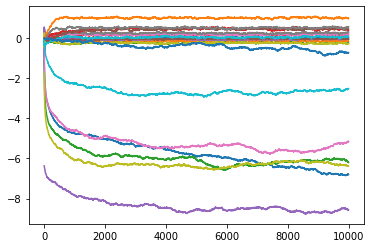

In [21]:
import matplotlib.pyplot as plt
plt.plot(all_thetas)
#plt.ylim(-3,-1)

In [ ]:
df = np.array(all_thetas)
#np.std(df[4000:], axis = 0)

In [ ]:
plt.plot(df[:,0:10])
#plt.plot(np.exp(0.5*df[:,10:20]))

In [ ]:
plt.plot(np.exp(0.5*df[:,10:20]))

In [ ]:
np.mean(acc)

In [ ]:
df = np.array(all_thetas)

In [ ]:
plt.plot(df[:,0:10])

In [ ]:
theta_hmc = np.mean(all_thetas[50:], axis = 0)
theta_hmc_sd = np.std(all_thetas[50:], axis = 0)
#np.save('../../../../data/commaai/mcmc/filtered_gaussian_resampled/Ridge/all_thetas.npy', np.array(all_taus[J[1]:]))

In [ ]:
theta_hmc

In [ ]:
# comparison with VA

In [ ]:
vartheta_va = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/mu_ts_delete.npy')

In [ ]:
vartheta_bts = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/B_ts_delete.npy')
vartheta_dts = np.load('../../../../../data/commaai/va/filtered_gaussian_resampled/Horseshoe/d_ts_delete.npy')

In [ ]:
B_ts = np.mean(vartheta_bts[10000:, :,:], axis = 0)
d_ts = np.mean(vartheta_dts[10000:, :,:], axis = 0)
va_sd = np.sqrt(np.diag(B_ts.dot(B_ts.T) + d_ts**2))

In [ ]:
theta_va = np.mean(vartheta_va[10000:, :,:], axis = 0)

In [ ]:
plt.scatter(theta_va[0:10], theta_hmc[0:10])
#plt.scatter(theta_va[10:20], theta_hmc[10:20])
#plt.scatter(theta_va[20], theta_hmc[20])
ident = [-.5, .5]
plt.plot(ident,ident)

In [ ]:
beta_va = theta_hmc[0:10]

In [ ]:
theta_va[0:10]

In [ ]:
plt.scatter(va_sd[0:10], theta_hmc_sd[0:10])
plt.scatter(va_sd[10:20], theta_hmc_sd[10:20])
plt.scatter(va_sd[20], theta_hmc_sd[20])
ident = [0, 1.0]
plt.plot(ident,ident)